# Auto Encoder

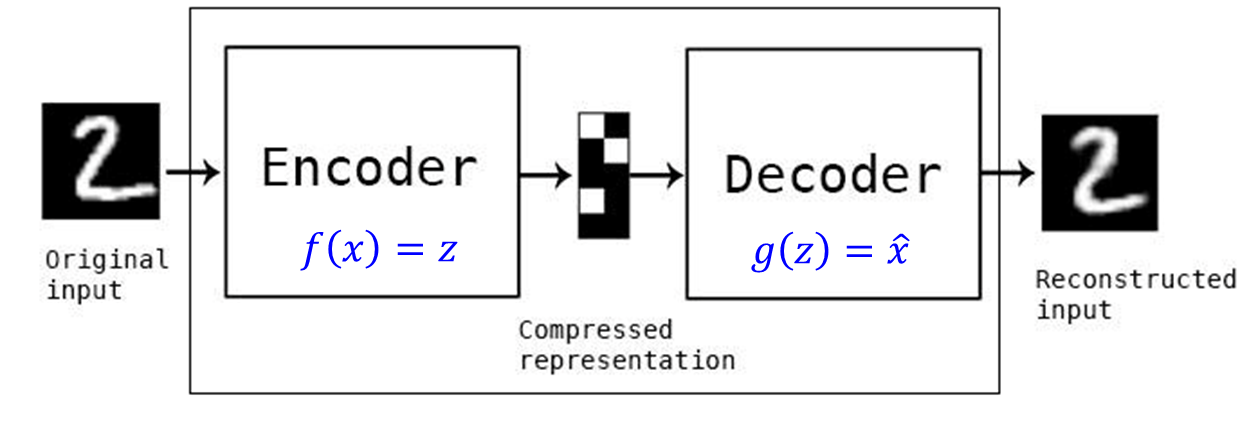

```
(1)The encoder compresses the input into a lower-dimensional latent space, and the decoder reconstructs the input from this compressed representation.
(2)Mainly used for dimensionality reduction, similar to PCA but more flexible due to its non-linear nature.
(3) Encoder轉換原本數據到一個新的空間，這個空間可以比原本Features描述的空間更能精準的描述數據。latent space 就是新的特徵空間裡的座標，可用這個新空間來判斷每筆Data之間的近似程度。

```
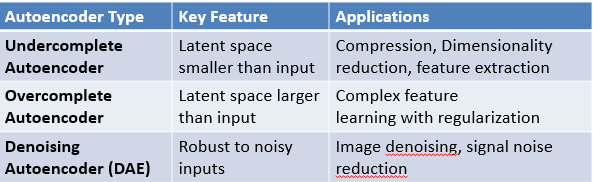

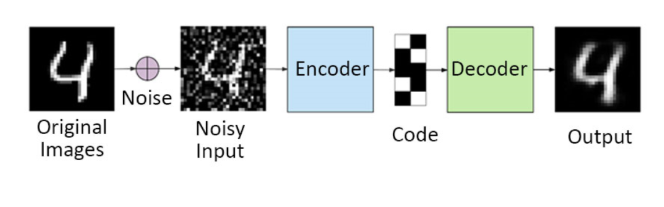

## 判別異常交異的方法
```
Autoencoders assume that normal data follows a specific pattern or distribution. Anomalies, by definition, do not fit this learned distribution, leading to poor reconstruction for outliers.
(1)AutoEncoder,Predict 結果愈接近原本輸入的X,則loss愈低, 若差很多, 則loss愈高。
(2)對於異常交易(outlier), 使用AutoEncoder也難以表達其重要潛在特徵, 故autoencoder 的輸出X和原始資料X差異甚大。而正常交易
autoencoder 的輸出X和原始資料X差異會較小。此和使用PCA與InverPCA transform 的在判斷異常交易的道理相同。

```


# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
#connectDrive()

# Change path
#changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

# Import Libraries

In [2]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

## Check library versions & set seed

In [3]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.3.2
tensorflow 2.4.1
keras      2.4.0
numpy      1.20.0


In [4]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF, if GPU is available.")

Default GPU Device: /device:GPU:0


# Data Preparation 

## Load the data

In [6]:
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [7]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

## Split into train and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

## Scale the data

In [9]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

featuresToScale = dataX.columns
sX = pp.StandardScaler()
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [10]:
X_train_AE, X_test_AE = X_train.copy(), X_test.copy()

## Define evaluation function and plotting function

In [11]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [12]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

# Model One 
## Two layer overcomplete autoencoder with linear activation

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [16]:
# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Epoch 1/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.2891 - accuracy: 0.7103 - val_loss: 0.0011 - val_accuracy: 0.9836
Epoch 2/10
5964/5964 [==============================] - 35s 6ms/step - loss: 0.0014 - accuracy: 0.9889 - val_loss: 5.0106e-06 - val_accuracy: 0.9990
Epoch 3/10
5964/5964 [==============================] - 35s 6ms/step - loss: 5.6253e-04 - accuracy: 0.9940 - val_loss: 3.0691e-04 - val_accuracy: 0.9937
Epoch 4/10
5964/5964 [==============================] - 35s 6ms/step - loss: 4.6805e-04 - accuracy: 0.9946 - val_loss: 8.5137e-06 - val_accuracy: 0.9988
Epoch 5/10
5964/5964 [==============================] - 36s 6ms/step - loss: 6.3032e-04 - accuracy: 0.9929 - val_loss: 6.6694e-05 - val_accuracy: 0.9966
Epoch 6/10
5964/5964 [==============================] - 36s 6ms/step - loss: 3.0317e-04 - accuracy: 0.9963 - val_loss: 5.9120e-04 - val_accuracy: 0.9883
Epoch 7/10
5964/5964 [==============================] - 36s 6ms/step - loss: 3.4278e-04 - accu

## Evaluate on Test Set

2938/2938 [==============================] - 3s 933us/step


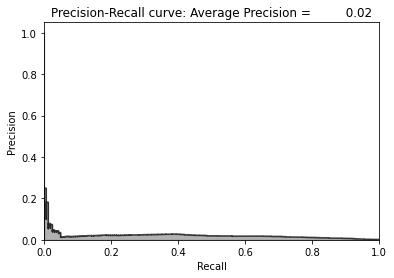

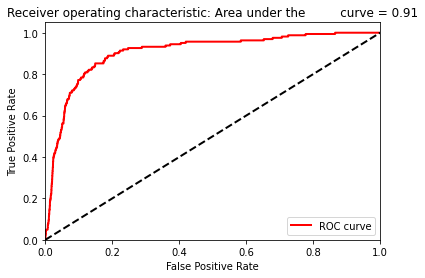

In [17]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Epoch 1/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.3308 - accuracy: 0.6682 - val_loss: 0.0019 - val_accuracy: 0.9778
Epoch 2/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.0014 - accuracy: 0.9886 - val_loss: 1.5908e-06 - val_accuracy: 0.9993
Epoch 3/10
5964/5964 [==============================] - 37s 6ms/step - loss: 5.9336e-04 - accuracy: 0.9939 - val_loss: 4.2303e-04 - val_accuracy: 0.9930
Epoch 4/10
5964/5964 [==============================] - 37s 6ms/step - loss: 3.9920e-04 - accuracy: 0.9953 - val_loss: 2.3430e-06 - val_accuracy: 0.9994
Epoch 5/10
5964/5964 [==============================] - 37s 6ms/step - loss: 4.5638e-04 - accuracy: 0.9950 - val_loss: 1.6159e-04 - val_accuracy: 0.9947
Epoch 6/10
5964/5964 [==============================] - 38s 6ms/step - loss: 2.9407e-04 - accuracy: 0.9961 - val_loss: 8.6358e-04 - val_accuracy: 0.9848
Epoch 7/10
5964/5964 [==============================] - 37s 6ms/step - loss: 2.4230e-04 - accu

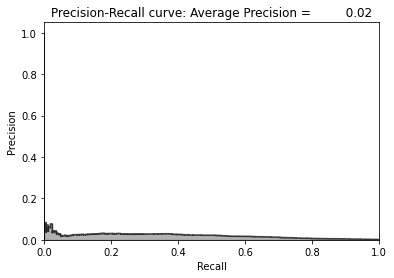

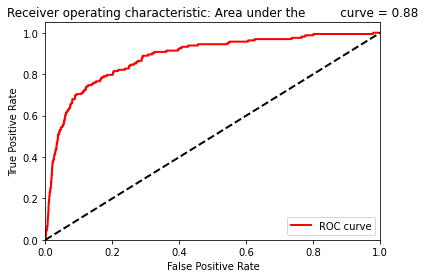

Mean average precision over 10 runs: 0.019969338929891958


[0.02]

In [18]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [19]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.02
Coefficient of variation over 10 runs: 0.0


[0.02]

# Model Two
## Two layer undercomplete autoencoder with linear activation
## 20 nodes in hidden layer

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.5200 - accuracy: 0.4822 - val_loss: 0.2780 - val_accuracy: 0.6435
Epoch 2/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.2821 - accuracy: 0.6348 - val_loss: 0.2753 - val_accuracy: 0.6338
Epoch 3/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.2869 - accuracy: 0.6418 - val_loss: 0.2740 - val_accuracy: 0.6413
Epoch 4/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.2711 - accuracy: 0.6485 - val_loss: 0.2744 - val_accuracy: 0.6533
Epoch 5/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.2784 - accuracy: 0.6443 - val_loss: 0.2732 - val_accuracy: 0.6609
Epoch 6/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.2679 - accuracy: 0.6644 - val_loss: 0.2735 - val_accuracy: 0.6584
Epoch 7/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.2713 - accuracy: 0.6646 - val_loss: 0.2736 - val_ac

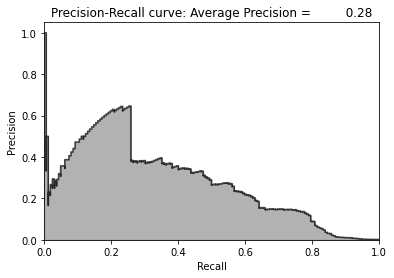

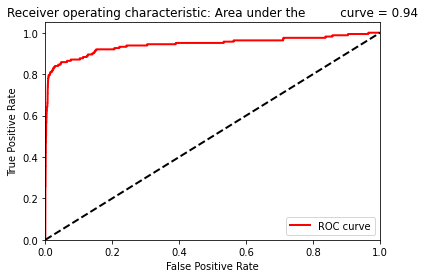

Mean average precision over 10 runs: 0.2799


[0.2799]

In [21]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [22]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2799
Coefficient of variation over 10 runs: 0.0


[0.2799]

# Model Two v2
## Two layer undercomplete autoencoder with linear activation 
## With 27 nodes this time 

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.3209 - accuracy: 0.6425 - val_loss: 0.0365 - val_accuracy: 0.8872
Epoch 2/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0368 - accuracy: 0.8912 - val_loss: 0.0373 - val_accuracy: 0.9247
Epoch 3/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0474 - accuracy: 0.9257 - val_loss: 0.0374 - val_accuracy: 0.9514
Epoch 4/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0393 - accuracy: 0.9541 - val_loss: 0.0377 - val_accuracy: 0.9516
Epoch 5/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0382 - accuracy: 0.9545 - val_loss: 0.0363 - val_accuracy: 0.9615
Epoch 6/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0360 - accuracy: 0.9592 - val_loss: 0.0376 - val_accuracy: 0.9510
Epoch 7/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0352 - accuracy: 0.9583 - val_loss: 0.0382 - val_ac

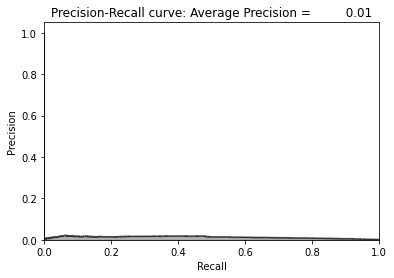

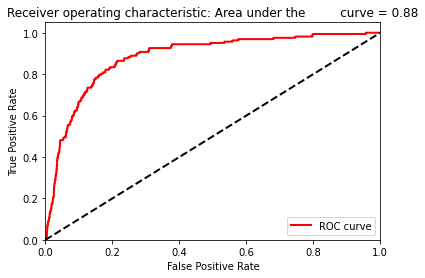

Mean average precision over 10 runs: 0.0128


[0.0128]

In [24]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [25]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0128
Coefficient of variation over 10 runs: 0.0


[0.0128]

# Model Three
## Three layer undercomplete autoencoder with linear activation.
## With 28 and 27 nodes in the two hidden layers, respectively

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 39s 7ms/step - loss: 0.3168 - accuracy: 0.6229 - val_loss: 0.0369 - val_accuracy: 0.9341
Epoch 2/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.0412 - accuracy: 0.9412 - val_loss: 0.0366 - val_accuracy: 0.9531
Epoch 3/10
5964/5964 [==============================] - 39s 7ms/step - loss: 0.0470 - accuracy: 0.9534 - val_loss: 0.0393 - val_accuracy: 0.9610
Epoch 4/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0389 - accuracy: 0.9632 - val_loss: 0.0384 - val_accuracy: 0.9571
Epoch 5/10
5964/5964 [==============================] - 39s 6ms/step - loss: 0.0397 - accuracy: 0.9581 - val_loss: 0.0363 - val_accuracy: 0.9685
Epoch 6/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0370 - accuracy: 0.9622 - val_loss: 0.0390 - val_accuracy: 0.9502
Epoch 7/10
5964/5964 [==============================] - 39s 6ms/step - loss: 0.0355 - accuracy: 0.9587 - val_loss: 0.0373 - val_ac

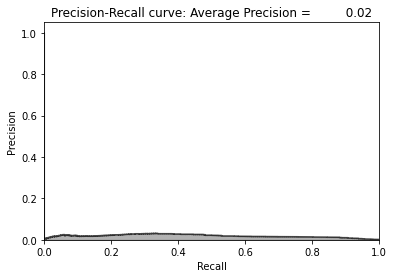

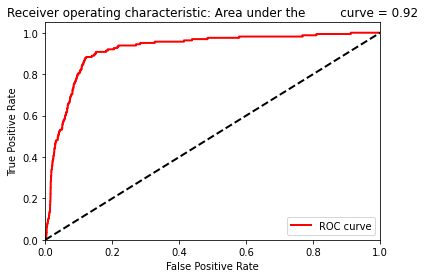

Mean average precision over 10 runs: 0.0189


[0.0189]

In [27]:
# 10 runs - We will capture mean of average precision
tf.random.set_seed(42)
np.random.seed(42)
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [28]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0189
Coefficient of variation over 10 runs: 0.0


[0.0189]

# Model Four
## Four layer undercomplete autoencoder with ReLu activation
## 29 -> 27 -> 22 -> 27 -> 29

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 45s 8ms/step - loss: 0.7649 - accuracy: 0.4434 - val_loss: 0.6325 - val_accuracy: 0.6923
Epoch 2/10
5964/5964 [==============================] - 45s 8ms/step - loss: 0.6291 - accuracy: 0.7116 - val_loss: 0.6221 - val_accuracy: 0.7304
Epoch 3/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.6264 - accuracy: 0.7306 - val_loss: 0.6207 - val_accuracy: 0.7279
Epoch 4/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.6158 - accuracy: 0.7358 - val_loss: 0.6219 - val_accuracy: 0.7154
Epoch 5/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.6271 - accuracy: 0.7411 - val_loss: 0.6177 - val_accuracy: 0.7497
Epoch 6/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.6125 - accuracy: 0.7481 - val_loss: 0.6188 - val_accuracy: 0.7386
Epoch 7/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.6157 - accuracy: 0.7496 - val_loss: 0.6243 - val_ac

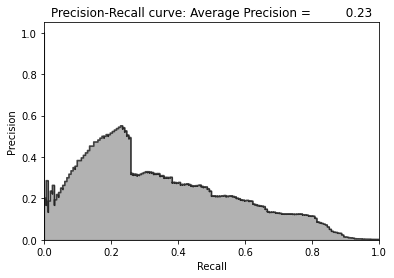

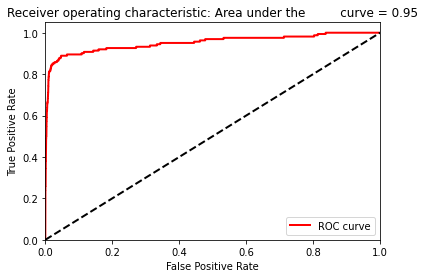

Mean average precision over 10 runs: 0.2292


[0.2292]

In [30]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [31]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2292
Coefficient of variation over 10 runs: 0.0


[0.2292]

# Model Five
## Two layer overcomplete autoencoder with linear activation
## 29 -> 40 -> 29

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.2050 - accuracy: 0.7910 - val_loss: 0.0011 - val_accuracy: 0.9762
Epoch 2/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0015 - accuracy: 0.9896 - val_loss: 2.5041e-04 - val_accuracy: 0.9937
Epoch 3/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.0012 - accuracy: 0.9926 - val_loss: 4.6329e-04 - val_accuracy: 0.9935
Epoch 4/10
5964/5964 [==============================] - 36s 6ms/step - loss: 3.9699e-04 - accuracy: 0.9947 - val_loss: 4.5684e-04 - val_accuracy: 0.9959
Epoch 5/10
5964/5964 [==============================] - 37s 6ms/step - loss: 8.2627e-04 - accuracy: 0.9920 - val_loss: 8.2839e-05 - val_accuracy: 0.9966
Epoch 6/10
5964/5964 [==============================] - 37s 6ms/step - loss: 3.1426e-04 - accuracy: 0.9967 - val_loss: 0.0017 - val_accuracy: 0.9806
Epoch 7/10
5964/5964 [==============================] - 37s 6ms/step - loss: 4.6392e-04 - accuracy: 0.

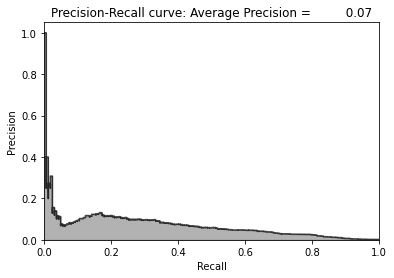

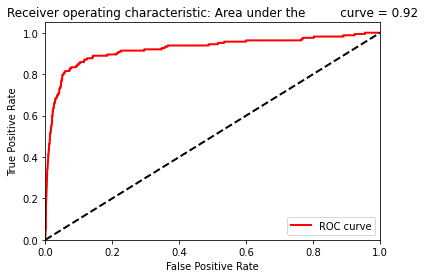

Mean average precision over 10 runs: 0.0707


[0.0707]

In [33]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [34]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0707
Coefficient of variation over 10 runs: 0.0


[0.0707]

# Model Six
## Two layer overcomplete autoencoder with linear activation and dropout
## 29 -> 40 -> 29
## Dropout percentage: 10%

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.2984 - accuracy: 0.6287 - val_loss: 0.0101 - val_accuracy: 0.9635
Epoch 2/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0771 - accuracy: 0.7832 - val_loss: 0.0077 - val_accuracy: 0.9731
Epoch 3/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0773 - accuracy: 0.7832 - val_loss: 0.0091 - val_accuracy: 0.9727
Epoch 4/10
5964/5964 [==============================] - 39s 7ms/step - loss: 0.0744 - accuracy: 0.7827 - val_loss: 0.0091 - val_accuracy: 0.9688
Epoch 5/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0771 - accuracy: 0.7835 - val_loss: 0.0075 - val_accuracy: 0.9739
Epoch 6/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0760 - accuracy: 0.7846 - val_loss: 0.0074 - val_accuracy: 0.9721
Epoch 7/10
5964/5964 [==============================] - 39s 7ms/step - loss: 0.0757 - accuracy: 0.7854 - val_loss: 0.0085 - val_ac

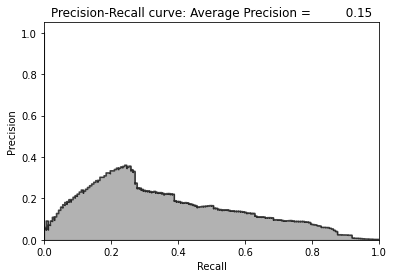

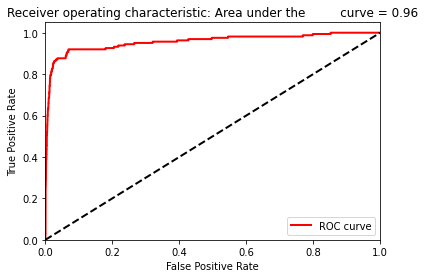

Mean average precision over 10 runs: 0.1539


[0.1539]

In [36]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [37]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.1539
Coefficient of variation over 10 runs: 0.0


[0.1539]

# Model Seven
## Two layer sparse overcomplete autoencoder with linear activation
## 29 -> 40 -> 29

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.2077 - accuracy: 0.7909 - val_loss: 0.0038 - val_accuracy: 0.9781
Epoch 2/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0041 - accuracy: 0.9897 - val_loss: 0.0023 - val_accuracy: 0.9955
Epoch 3/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0032 - accuracy: 0.9923 - val_loss: 0.0027 - val_accuracy: 0.9902
Epoch 4/10
5964/5964 [==============================] - 47s 8ms/step - loss: 0.0024 - accuracy: 0.9938 - val_loss: 0.0017 - val_accuracy: 0.9992
Epoch 5/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0024 - accuracy: 0.9923 - val_loss: 0.0017 - val_accuracy: 0.9953
Epoch 6/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0020 - accuracy: 0.9948 - val_loss: 0.0032 - val_accuracy: 0.9817
Epoch 7/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0021 - accuracy: 0.9933 - val_loss: 0.0029 - val_ac

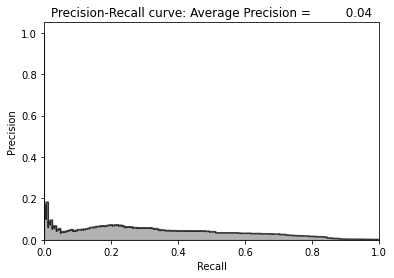

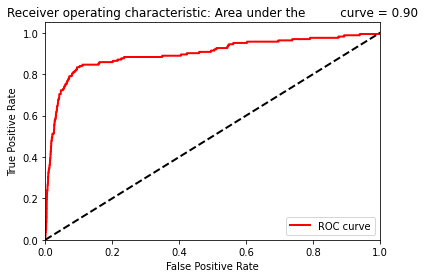

Mean average precision over 10 runs: 0.0385


[0.0385]

In [39]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [40]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0385
Coefficient of variation over 10 runs: 0.0


[0.0385]

# Model Eight
## Two layer sparse overcomplete autoencoder with linear activation and dropout
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.2588 - accuracy: 0.6891 - val_loss: 0.0079 - val_accuracy: 0.9656
Epoch 2/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0412 - accuracy: 0.8589 - val_loss: 0.0051 - val_accuracy: 0.9793
Epoch 3/10
5964/5964 [==============================] - 45s 7ms/step - loss: 0.0398 - accuracy: 0.8616 - val_loss: 0.0061 - val_accuracy: 0.9774
Epoch 4/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0391 - accuracy: 0.8590 - val_loss: 0.0058 - val_accuracy: 0.9779
Epoch 5/10
5964/5964 [==============================] - 45s 7ms/step - loss: 0.0405 - accuracy: 0.8593 - val_loss: 0.0043 - val_accuracy: 0.9799
Epoch 6/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0399 - accuracy: 0.8601 - val_loss: 0.0052 - val_accuracy: 0.9767
Epoch 7/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0394 - accuracy: 0.8627 - val_loss: 0.0050 - val_ac

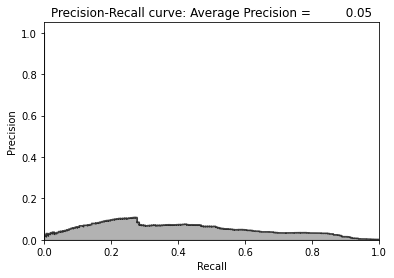

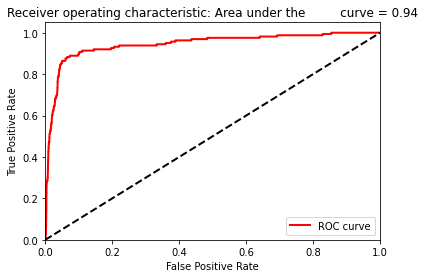

Mean average precision over 10 runs: 0.0522


[0.0522]

In [42]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [43]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0522
Coefficient of variation over 10 runs: 0.0


[0.0522]

# Model Nine
## Two layer denoising undercomplete autoencoder with linear activation
## 29 -> 27 -> 29

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.3727 - accuracy: 0.6286 - val_loss: 0.0365 - val_accuracy: 0.8961
Epoch 2/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0556 - accuracy: 0.8654 - val_loss: 0.0362 - val_accuracy: 0.9092
Epoch 3/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0575 - accuracy: 0.8698 - val_loss: 0.0356 - val_accuracy: 0.8923
Epoch 4/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.0546 - accuracy: 0.8712 - val_loss: 0.0365 - val_accuracy: 0.9097
Epoch 5/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0546 - accuracy: 0.8823 - val_loss: 0.0362 - val_accuracy: 0.9192
Epoch 6/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.0544 - accuracy: 0.8865 - val_loss: 0.0372 - val_accuracy: 0.9112
Epoch 7/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0525 - accuracy: 0.8893 - val_loss: 0.0366 - val_ac

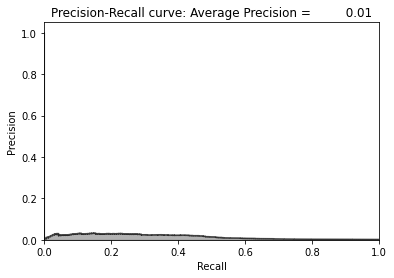

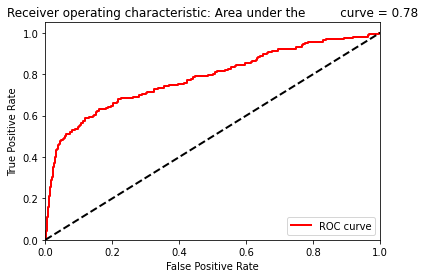

Mean average precision over 10 runs: 0.0148


[0.0148]

In [45]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [46]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0148
Coefficient of variation over 10 runs: 0.0


[0.0148]

# Model Ten
## Two layer denoising overcomplete autoencoder with linear activation
## And sparsity regularizer and dropout  
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 45s 7ms/step - loss: 0.2963 - accuracy: 0.6827 - val_loss: 0.0062 - val_accuracy: 0.9705
Epoch 2/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0508 - accuracy: 0.8486 - val_loss: 0.0049 - val_accuracy: 0.9806
Epoch 3/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.0493 - accuracy: 0.8456 - val_loss: 0.0053 - val_accuracy: 0.9807
Epoch 4/10
5964/5964 [==============================] - 45s 8ms/step - loss: 0.0489 - accuracy: 0.8468 - val_loss: 0.0050 - val_accuracy: 0.9807
Epoch 5/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0502 - accuracy: 0.8471 - val_loss: 0.0041 - val_accuracy: 0.9803
Epoch 6/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0499 - accuracy: 0.8478 - val_loss: 0.0044 - val_accuracy: 0.9786
Epoch 7/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0490 - accuracy: 0.8485 - val_loss: 0.0045 - val_ac

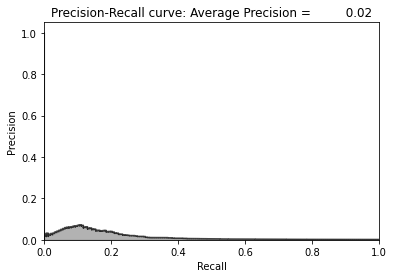

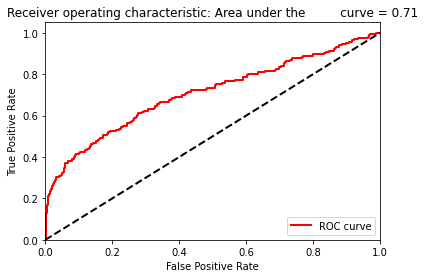

Mean average precision over 10 runs: 0.0155


[0.0155]

In [48]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [49]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0155
Coefficient of variation over 10 runs: 0.0


[0.0155]

# Model Eleven
## Two layer denoising overcomplete autoencoder with ReLU activation
## And sparsity regularizer and dropout  
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.4365 - accuracy: 0.5372 - val_loss: 0.0228 - val_accuracy: 0.9172
Epoch 2/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.1360 - accuracy: 0.7204 - val_loss: 0.0184 - val_accuracy: 0.9130
Epoch 3/10
5964/5964 [==============================] - 45s 7ms/step - loss: 0.1267 - accuracy: 0.7291 - val_loss: 0.0152 - val_accuracy: 0.9225
Epoch 4/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.1177 - accuracy: 0.7337 - val_loss: 0.0155 - val_accuracy: 0.9174
Epoch 5/10
5964/5964 [==============================] - 48s 8ms/step - loss: 0.1180 - accuracy: 0.7330 - val_loss: 0.0128 - val_accuracy: 0.9232
Epoch 6/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.1175 - accuracy: 0.7349 - val_loss: 0.0135 - val_accuracy: 0.9232
Epoch 7/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.1147 - accuracy: 0.7361 - val_loss: 0.0129 - val_ac

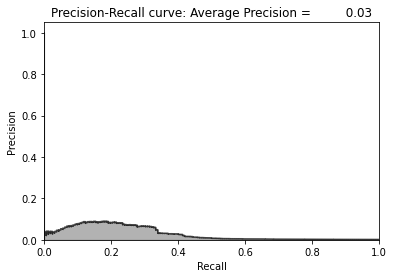

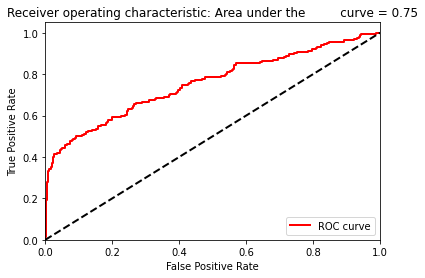

Mean average precision over 10 runs: 0.0289


[0.0289]

In [51]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [52]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0289
Coefficient of variation over 10 runs: 0.0


[0.0289]

# Conclusion

In [53]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2024-08-18 23:36:56.836364


## 結論: 

Two layer undercomplete autoencoder with linear activation (20 nodes in one hidden layer) 的表現最好, 但也僅僅0.28. 
次佳的是0.22, 使用 Four layer undercomplete autoencoder with ReLu activation (29 -> 27 -> 22 -> 27 -> 29)
